In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2
import sklearn
from mnist import MNIST
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

mndata = MNIST('./samples')
x_train, y_train = mndata.load_training()
x_test, y_test = mndata.load_testing()
x_stretched = []
x_test_s = []
(60000,)
# Thresholding and Stretching

print("Start treating train data")
for i in range(60000):
    if (i % 20000 == 0):
        print((i/60000 * 100), "% complete")
    up = -1
    down = -1
    left = -1
    right = -1
    for j in range(784):
        if (x_train[i][j] <= 127):
            x_train[i][j] = 0
        else:
            x_train[i][j] = 1
            if (up == -1):
                up = j//28
            if (down == -1 or j//28 > down):
                down = j//28
            if (left == -1 or j%28 < left):
                left = j%28
            if (right == -1 or j%28 > right):
                right = j%28
    temp = np.reshape(x_train[i], (28,28))
    x_temp = temp[up:(down+1), left:(right+1)]
    x_resized = cv2.resize(x_temp, (20,20), interpolation = cv2.INTER_NEAREST)
    x_stretched.append(np.reshape(x_resized,(400,)))

print("Start treating test data")
for i in range(10000):
    up = -1
    down = -1
    left = -1
    right = -1
    for j in range(784):
        if (x_test[i][j] <= 127):
            x_test[i][j] = 0
        else:
            x_test[i][j] = 1
            if (up == -1):
                up = j//28
            if (down == -1 or j//28 > down):
                down = j//28
            if (left == -1 or j%28 < left):
                left = j%28
            if (right == -1 or j%28 > right):
                right = j%28
    temp = np.reshape(x_test[i], (28,28))
    x_temp = temp[up:(down+1), left:(right+1)]
    x_resized = cv2.resize(x_temp, (20,20), interpolation = cv2.INTER_NEAREST)
    x_test_s.append(np.reshape(x_resized,(400,)))


print("done")

Start treating train data
0.0 % complete
33.33333333333333 % complete
66.66666666666666 % complete
Start treating test data
done


In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# x_train = x_stretched
# x_test = x_test_s
def run(x_train_t, x_test_t, y_train_t, y_test_t, train_size, test_size):
    # print("Start vectorzing")
    label_data = []
    label_counter = np.zeros(10)
    for i in range(10):
        label_data.append([])
    for i in range(train_size):
        label_data[y_train_t[i]].append(np.copy(x_train_t[i]))
        label_counter[y_train_t[i]] += 1
    
    label_prob = [arr/train_size for arr in label_counter]
    mean_arr = [np.mean(arr, axis=0) for arr in label_data]
    var_arr = [np.var(arr, axis=0) + 0.02 for arr in label_data]
    
    norm_arr = []   
    for i in range(0,10):
        norm_arr.append([])
        norm_temp = np.log(norm.pdf(x_test_t, mean_arr[i], np.sqrt(var_arr[i])) + 1e-15)
        norm_arr[i] = [np.sum(arr) + np.log(label_prob[i]) for arr in norm_temp]
    p = 0
    
    for i in range(test_size):
        max_id, max_val = 0, norm_arr[0][i] 
        for j in range(0,10):
            if(norm_arr[j][i] > max_val):
                max_val = norm_arr[j][i]
                max_id = j
        if(y_test_t[i] == max_id):
            p += 1
    print("Final accuracy: ", p/test_size)

In [13]:
run(x_train, x_test, y_train, y_test, 60000, 10000)
run(x_train, x_train, y_train, y_train, 60000, 60000)
run(x_stretched, x_test_s, y_train, y_test, 60000, 10000)
run(x_stretched, x_stretched, y_train, y_train, 60000, 60000)

Final accuracy:  0.8052
Final accuracy:  0.7950166666666667
Final accuracy:  0.8352
Final accuracy:  0.82805


In [14]:
# x_train = x_stretched
# x_test = x_test_s

def run_bernoulli(x_train_t, x_test_t, y_train_t, y_test_t, train_size, test_size):
    # print("Start vectorzing")
    label_data = []
    label_counter = np.zeros(10)
    for i in range(10):
        label_data.append([])
    for i in range(train_size):
        label_data[y_train_t[i]].append(np.copy(x_train_t[i]))
        label_counter[y_train_t[i]] += 1
    label_prob = [arr/train_size for arr in label_counter]

    p_arr = []
    for i in range(10):
        p_arr.append((np.sum(label_data[i], axis = 0) + 1)/(label_counter[i] + 2))

    bayes_arr = []
    p_arr = np.asarray(p_arr)
    x_test_t = np.asarray(x_test_t)
    for i in range(0,10):
        bayes_arr.append([])
        bernoulli_temp = np.log(p_arr[i] * x_test_t + (1 - p_arr[i])*(1-x_test_t))
        bayes_arr[i] = [np.sum(arr) + np.log(label_prob[i]) for arr in bernoulli_temp]

    p = 0
    for i in range(test_size):
        max_id, max_val = 0, bayes_arr[0][i] 
        for j in range(0,10):
            if(bayes_arr[j][i] > max_val):
                max_val = bayes_arr[j][i]
                max_id = j
        if(y_test_t[i] == max_id):
            p += 1
    print("Final accuracy: ", p/test_size)

In [15]:
run_bernoulli(x_train, x_test, y_train, y_test, 60000, 10000)
run_bernoulli(x_train, x_train, y_train, y_train, 60000, 60000)
run_bernoulli(x_stretched, x_test_s, y_train, y_test, 60000, 10000)
run_bernoulli(x_stretched, x_stretched, y_train, y_train, 60000, 60000)

Final accuracy:  0.8427
Final accuracy:  0.8357666666666667
Final accuracy:  0.8301
Final accuracy:  0.8188166666666666


In [16]:
trees = [(10, 4), (10, 16), (30, 4), (30, 16)]

for (nums, depth) in trees:
    clf = RandomForestClassifier(n_estimators = nums, max_depth = depth, random_state = 0)
    clf.fit(x_train, y_train)
    print("Final accuracy: ", accuracy_score(np.asarray(y_train), clf.predict(x_train)))
    print("Final accuracy: ", accuracy_score(np.asarray(y_test), clf.predict(x_test)))
    clf2 = RandomForestClassifier(n_estimators = nums, max_depth = depth, random_state = 0)
    clf2.fit(x_stretched, y_train)
    print("Final accuracy: ", accuracy_score(np.asarray(y_train), clf2.predict(x_stretched)))
    print("Final accuracy: ", accuracy_score(np.asarray(y_test), clf2.predict(x_test_s)))

Final accuracy:  0.67585
Final accuracy:  0.6909
Final accuracy:  0.7132166666666667
Final accuracy:  0.7223
Final accuracy:  0.99025
Final accuracy:  0.9384
Final accuracy:  0.99465
Final accuracy:  0.9469
Final accuracy:  0.7205166666666667
Final accuracy:  0.7311
Final accuracy:  0.7461833333333333
Final accuracy:  0.754
Final accuracy:  0.9943833333333333
Final accuracy:  0.956
Final accuracy:  0.9972333333333333
Final accuracy:  0.9623


In [18]:
def draw(x_train_t, y_train_t, train_size, index):
    # print("Start vectorzing")
    label_data = []
    label_counter = np.zeros(10)
    for i in range(10):
        label_data.append([])
    for i in range(train_size):
        label_data[y_train_t[i]].append(np.copy(x_train_t[i]))
        label_counter[y_train_t[i]] += 1
    label_prob = [arr/train_size for arr in label_counter]
    mean_arr = [np.mean(arr, axis=0) for arr in label_data]
    plt.imshow(np.resize(mean_arr[index],(28,28)), interpolation='nearest')
    plt.show()

<IPython.core.display.Javascript object>


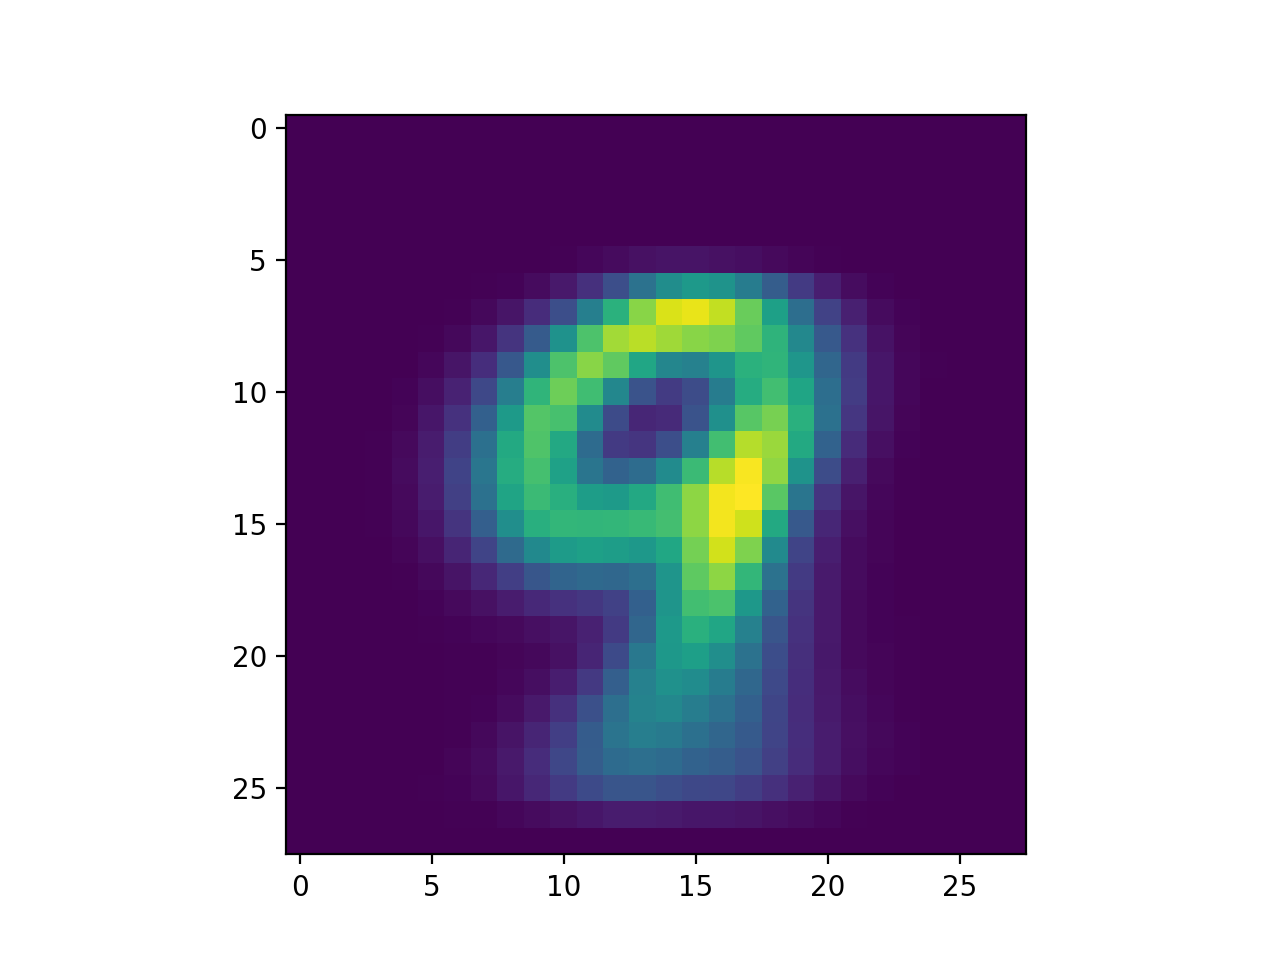

In [28]:
draw(x_train, y_train, 60000, 9) 